In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import emoji
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers.legacy import SGD, Adam, RMSprop, Adamax
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [154]:
df = pd.read_csv('Tweets.csv')

In [155]:
print("Tweets Dataset Description:")
print("---------------------------------")
print(df.describe(include='all'))

# Displaying the first few rows this will help us understand that how the dataset is looking like 
print("\nSome Entries:")
print(df.head())

# Ecah columns with it's datatypes 
print("\nData Types and Missing Values:")
print(df.info())

# Total number of entries and the variables in the dataset
entries, variables = df.shape
print("\nNumber of entries:", entries)
print("Number of variables:", variables)

# Counting the unique values in the 'airline_sentiment' column this will help us to understand the distributions
sentiment_counts = df['airline_sentiment'].value_counts()
print("\nDistribution of Sentiments:")
print(sentiment_counts)

Tweets Dataset Description:
---------------------------------
            tweet_id airline_sentiment  airline_sentiment_confidence  \
count   1.464000e+04             14640                  14640.000000   
unique           NaN                 3                           NaN   
top              NaN          negative                           NaN   
freq             NaN              9178                           NaN   
mean    5.692184e+17               NaN                      0.900169   
std     7.791112e+14               NaN                      0.162830   
min     5.675883e+17               NaN                      0.335000   
25%     5.685592e+17               NaN                      0.692300   
50%     5.694779e+17               NaN                      1.000000   
75%     5.698905e+17               NaN                      1.000000   
max     5.703106e+17               NaN                      1.000000   

                negativereason  negativereason_confidence airline  \
coun

In [156]:
print(df['airline_sentiment'].value_counts())

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


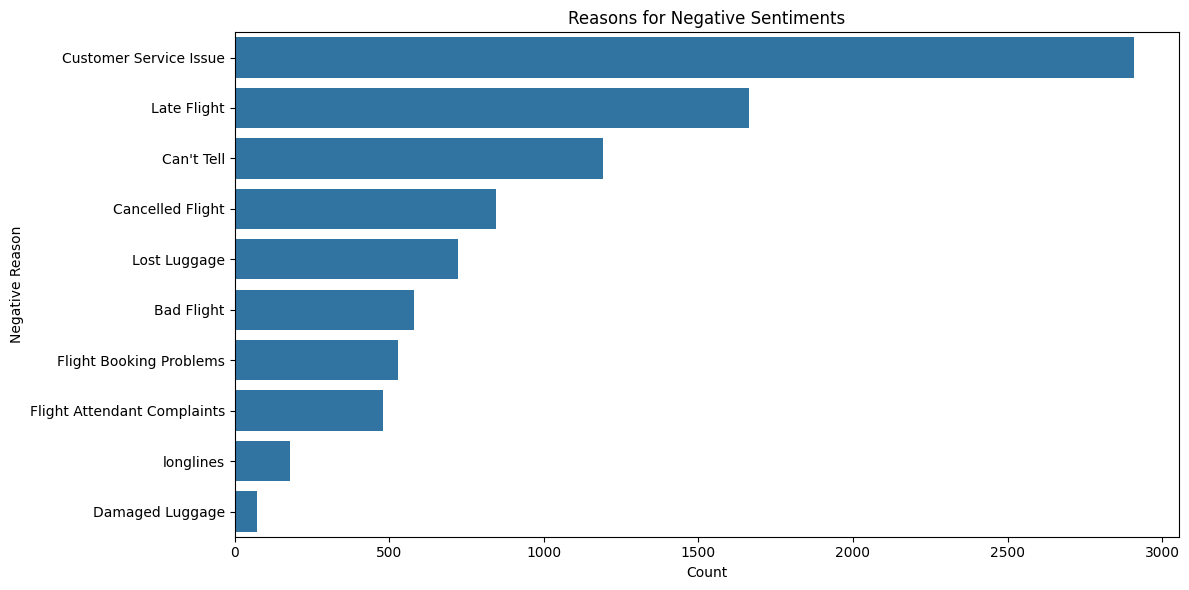

In [157]:
# Visualization of the major reasons for the negative sentiments 
neg_reasons = df[df['airline_sentiment'] == 'negative']['negativereason']
plt.figure(figsize=(12, 6))
sns.countplot(y=neg_reasons, order = neg_reasons.value_counts().index)
plt.title('Reasons for Negative Sentiments')
plt.xlabel('Count')
plt.ylabel('Negative Reason')
plt.tight_layout()


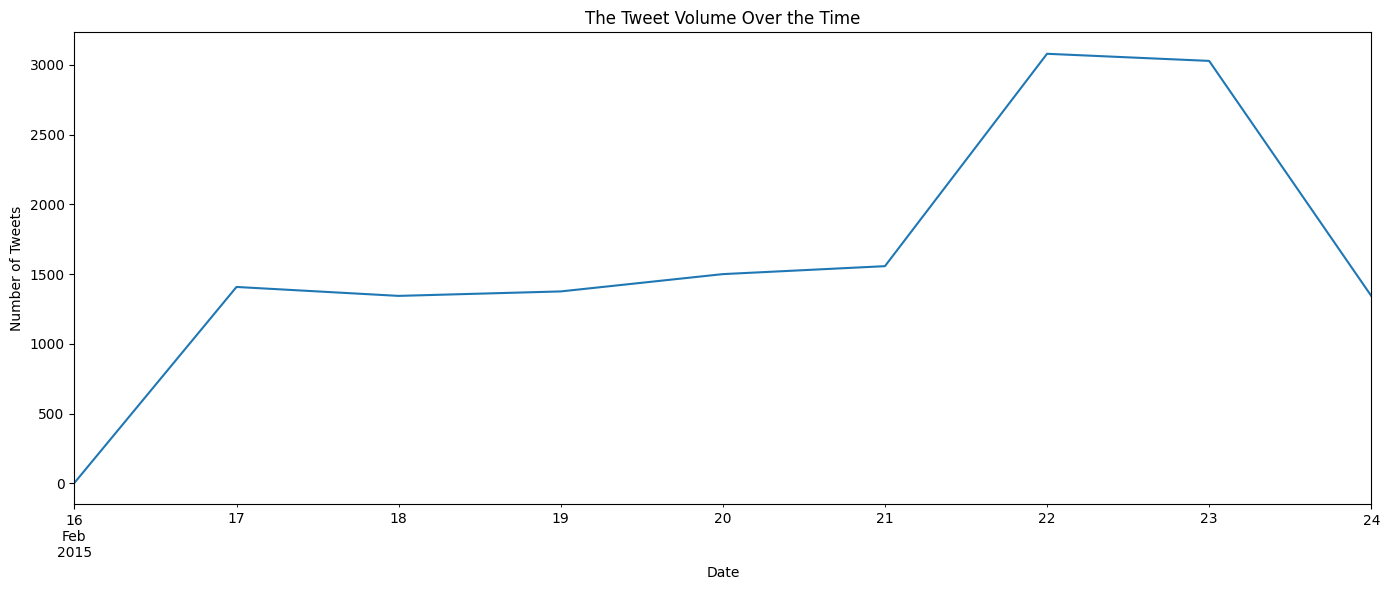

In [158]:
# The visualisation of the Sentiment Over Time and this is based on the 'tweet_created' timestamp
# Doing the preprocessung the 'tweet_created' feature to a date time format for the visualisation.
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
df.set_index('tweet_created', inplace=True)
df_resampled = df.resample('D').size()  # Performing the Daily resampling

plt.figure(figsize=(14, 6))
df_resampled.plot()
plt.title('The Tweet Volume Over the Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.tight_layout()

/var/folders/p6/bv6r8v75415bfb0z_27snkz00000gn/T/ipykernel_77793/4267888114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='airline_sentiment', y='airline_sentiment_confidence', data=df, palette="cool")


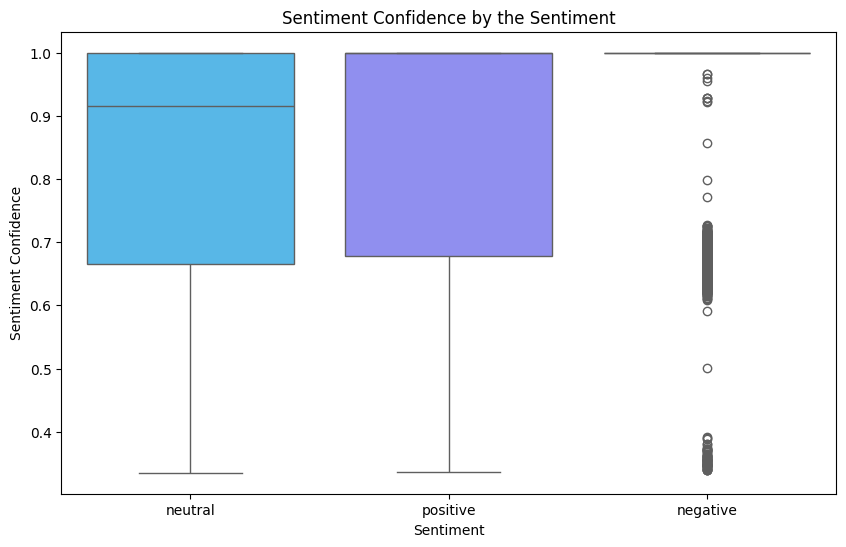

In [159]:
# Visualization of the Boxplot for the Sentiment Confidence categorised by the Sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='airline_sentiment', y='airline_sentiment_confidence', data=df, palette="cool")
plt.title('Sentiment Confidence by the Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Confidence')
plt.show()

/var/folders/p6/bv6r8v75415bfb0z_27snkz00000gn/T/ipykernel_77793/878610504.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='airline', y='airline_sentiment_confidence', data=df, palette="cool", ci=None)
/var/folders/p6/bv6r8v75415bfb0z_27snkz00000gn/T/ipykernel_77793/878610504.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='airline', y='airline_sentiment_confidence', data=df, palette="cool", ci=None)


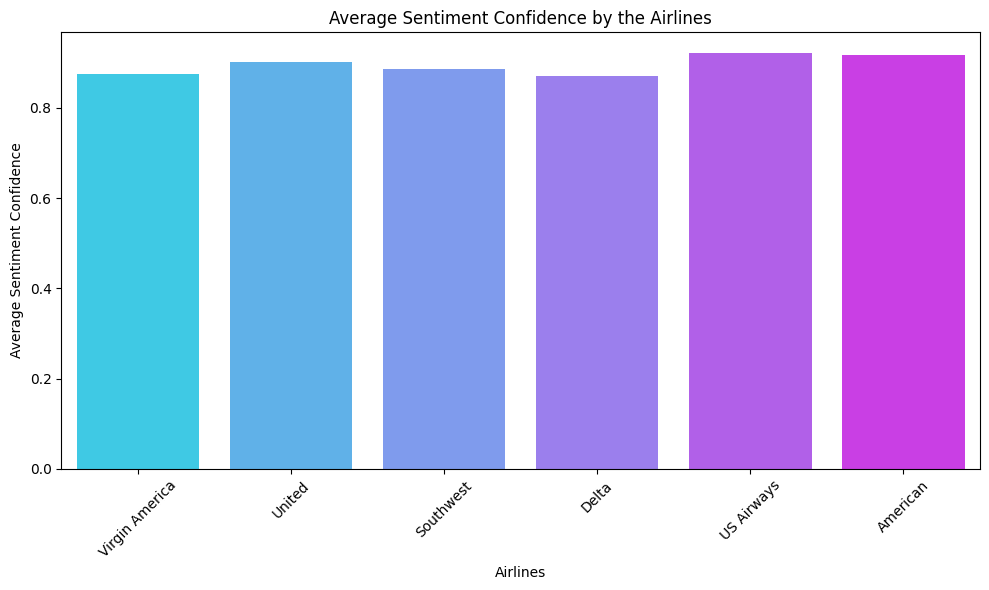

In [160]:
# Visualization of the Average Sentiment Confidence by each of the Airline
plt.figure(figsize=(10, 6))
sns.barplot(x='airline', y='airline_sentiment_confidence', data=df, palette="cool", ci=None)
plt.title('Average Sentiment Confidence by the Airlines')
plt.xticks(rotation=45)
plt.xlabel('Airlines')
plt.ylabel('Average Sentiment Confidence')
plt.tight_layout()
plt.show()

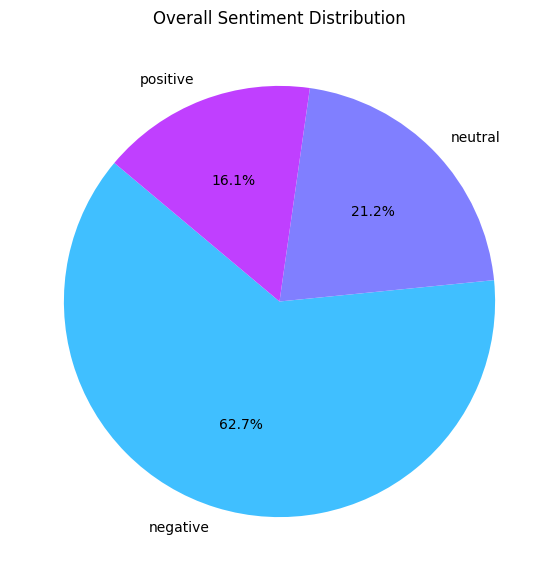

In [161]:
all_sentiments = df['airline_sentiment'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(all_sentiments, labels=all_sentiments.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("cool", len(all_sentiments)))
plt.title('Overall Sentiment Distribution')
plt.show()

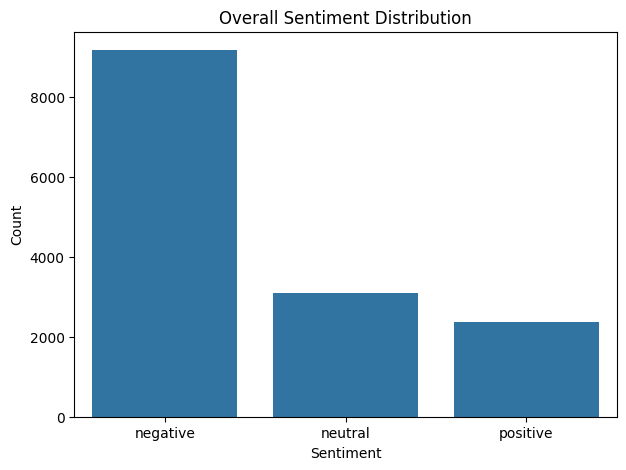

In [162]:
plt.figure(figsize=(7, 5))
sns.countplot(x='airline_sentiment', data=df, order = df['airline_sentiment'].value_counts().index)
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [163]:
df = df.reset_index(drop=True)

# Reindexing with a random permutation
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
5086,"@SouthwestAir Flight Cancelled Flighted, two h...",negative
4747,@SouthwestAir flight 1028 no delayed 1.5 hours...,negative
2870,@united @bobwesson fair enough United. everybo...,negative
12566,"@AmericanAir I love the Admiral Clubs! Thanks,...",positive
1856,@united what's the status of flight 1008 Bogot...,neutral


In [164]:
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))  # Adjust the language as necessary

def cleaning_text_data(text):
    # Removing the emojis from the tweets
    removing_emojis = re.sub(emoji.get_emoji_regexp(), "", text)
    
    # The Lowercase, replacing the newlines, and removing links, mentions, and other characters
    text_cleaned = removing_emojis.replace('\r', ' ').replace('\n', ' ').lower()
    text_cleaned = re.sub(r"(?:\@|https?\://)\S+", "", text_cleaned)  # Removing links and mentions from the tweets
    text_cleaned = re.sub(r'[^\x00-\x7f]', '', text_cleaned)  # Removing non-ASCII chars from the tweets
    
    # Removing the punctuation and also specific unwanted characters
    unwanted_chars = string.punctuation + 'Ã±ã¼â»§'
    char_trans_table = str.maketrans('', '', unwanted_chars)
    text_cleaned = text_cleaned.translate(char_trans_table)
    
    # Cleaning the hashtag symbols from the tweets
    text_cleaned = " ".join(word.strip() for word in re.split('#|_', text_cleaned))
    
    # Removing the multiple spaces that are present
    text_cleaned = re.sub("\s\s+", " ", text_cleaned)
    
    # New Step: Splitting the cleaned text into words and removing stopwords
    words = text_cleaned.split()
    filtered_text = " ".join(word for word in words if word not in stop_words)
    
    return filtered_text

# Applying the cleaning function with stopwords removal to each text entry in the dataset
cleaned_texts = [cleaning_text_data(text) for text in df['text']]

# Incorporating the cleaned texts back into the DataFrame
df['cleaned_text'] = cleaned_texts

/var/folders/p6/bv6r8v75415bfb0z_27snkz00000gn/T/ipykernel_77793/3268542037.py:7: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  removing_emojis = re.sub(emoji.get_emoji_regexp(), "", text)


In [165]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# Preprocessing the text
def preprocess_text(text):
    # Removing the punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # removing the unwanted single characters 
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Removing the multiple spaces in the tweets
    text = re.sub(r'\s+', ' ', text)
    # converting the tweets into lower case
    text = text.lower()
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text
    
df['cleaned_text'] = df['text'].apply(preprocess_text)
print(df.head())

                                                    text airline_sentiment  \
5086   @SouthwestAir Flight Cancelled Flighted, two h...          negative   
4747   @SouthwestAir flight 1028 no delayed 1.5 hours...          negative   
2870   @united @bobwesson fair enough United. everybo...          negative   
12566  @AmericanAir I love the Admiral Clubs! Thanks,...          positive   
1856   @united what's the status of flight 1008 Bogot...           neutral   

                                            cleaned_text  
5086   southwestair flight cancelled flighted two hou...  
4747   southwestair flight delayed hour another week ...  
2870   united bobwesson fair enough united everybody ...  
12566    americanair love admiral club thanks hey follow  
1856                  united status flight bogot houston  


In [166]:
df = df[['airline_sentiment', 'text']].copy()

In [167]:
# Creating a mapping dictionary that converts the sentiment labels to the numerical values
targetDict_Sn = {'positive': 1, 'negative': 0, 'neutral': 2}
# Further Removing the leading and trailing whitespaces from 'airline_sentiment' feature
df['airline_sentiment'] = df['airline_sentiment'].str.strip()
# Applying the mapping to create a new 'target' feature with numerical sentiment values
df['target'] = df['airline_sentiment'].map(targetDict_Sn)
df.head()

,airline_sentiment,text,target
5086,negative,"@SouthwestAir Flight Cancelled Flighted, two h...",0
4747,negative,@SouthwestAir flight 1028 no delayed 1.5 hours...,0
2870,negative,@united @bobwesson fair enough United. everybo...,0
12566,positive,"@AmericanAir I love the Admiral Clubs! Thanks,...",1
1856,neutral,@united what's the status of flight 1008 Bogot...,2


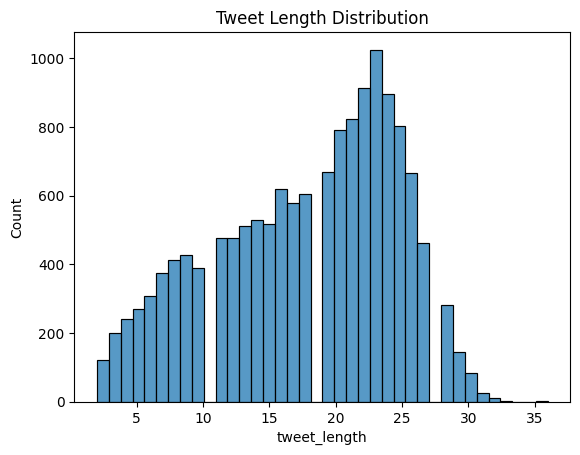

In [168]:
# Visualization of the Tweet length distribution
df['tweet_length'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['tweet_length'])
plt.title('Tweet Length Distribution')
plt.show()

In [169]:
df.head()

,airline_sentiment,text,target,tweet_length
5086,negative,"@SouthwestAir Flight Cancelled Flighted, two h...",0,18
4747,negative,@SouthwestAir flight 1028 no delayed 1.5 hours...,0,12
2870,negative,@united @bobwesson fair enough United. everybo...,0,22
12566,positive,"@AmericanAir I love the Admiral Clubs! Thanks,...",1,12
1856,neutral,@united what's the status of flight 1008 Bogot...,2,8


In [170]:
# Additional Preprocessing steps 
# Dropping the duplicate entries 
df.drop_duplicates()

,airline_sentiment,text,target,tweet_length
5086,negative,"@SouthwestAir Flight Cancelled Flighted, two h...",0,18
4747,negative,@SouthwestAir flight 1028 no delayed 1.5 hours...,0,12
2870,negative,@united @bobwesson fair enough United. everybo...,0,22
12566,positive,"@AmericanAir I love the Admiral Clubs! Thanks,...",1,12
1856,neutral,@united what's the status of flight 1008 Bogot...,2,8
...,...,...,...,...
12438,negative,@AmericanAir this has to be the absolute WORST...,0,10
11572,negative,@USAirways 325 minute delay - this is absurd. ...,0,14
7277,negative,@JetBlue 👍. I think I'll come take a nap at th...,0,13
6511,positive,@SouthwestAir No worries at all!!! I would rat...,1,24


In [171]:
# Checeking for the Null values 
df.isnull()

,airline_sentiment,text,target,tweet_length
5086,False,False,False,False
4747,False,False,False,False
2870,False,False,False,False
12566,False,False,False,False
1856,False,False,False,False
...,...,...,...,...
12438,False,False,False,False
11572,False,False,False,False
7277,False,False,False,False
6511,False,False,False,False


In [172]:
# Removing the rows which are having the NAN values 
df.dropna()

,airline_sentiment,text,target,tweet_length
5086,negative,"@SouthwestAir Flight Cancelled Flighted, two h...",0,18
4747,negative,@SouthwestAir flight 1028 no delayed 1.5 hours...,0,12
2870,negative,@united @bobwesson fair enough United. everybo...,0,22
12566,positive,"@AmericanAir I love the Admiral Clubs! Thanks,...",1,12
1856,neutral,@united what's the status of flight 1008 Bogot...,2,8
...,...,...,...,...
12438,negative,@AmericanAir this has to be the absolute WORST...,0,10
11572,negative,@USAirways 325 minute delay - this is absurd. ...,0,14
7277,negative,@JetBlue 👍. I think I'll come take a nap at th...,0,13
6511,positive,@SouthwestAir No worries at all!!! I would rat...,1,24


In [173]:
df.shape

(14640, 4)

In [174]:
df['text'] = cleaned_texts
# rearrangeinf the order of the colum for the better understanding 
df = df.reindex(columns=['text','cleaned_text', 'airline_sentiment'])
df.head()

,text,cleaned_text,airline_sentiment
5086,flight cancelled flighted two hours hold hangs...,NaN,negative
4747,flight 1028 delayed 15 hours another week anot...,NaN,negative
2870,fair enough united everybody best although sli...,NaN,negative
12566,love admiral clubs thanks hey follow,NaN,positive
1856,whats status flight 1008 bogothouston,NaN,neutral


In [175]:
tokenizer = Tokenizer(num_words=512, lower=True, split=' ')
tokenizer.fit_on_texts(df['text'])

In [176]:
#Converting the text to the sequences of numeric values
sequence_conversion = tokenizer.texts_to_sequences(df['text'])
#Definig the maximum length of a sequence
maxLen = 32
#Padding the sequences to ensure that uniform input size
padData = pad_sequences(sequence_conversion, padding='post', maxlen=maxLen)

#Encoding the sentiment labels into one-hot vectors
one_hot_labels = pd.get_dummies(df['airline_sentiment']).astype(int)

# Splitting the dataset into the training, validation, and testing sets 
train_data, test_data, train_labels, test_labels = train_test_split(padData, one_hot_labels, test_size=0.25, random_state=1)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=1)

# Defining the architecture parameters
vocab_size_sn = 3000 # Vocabulary size
embed_size_sn = 32 # Size of the embedding vectors
epochs = 10 
first_learningrate = 0.05 # learning rate
lr_decay = first_learningrate / epochs # Learning rate decay over the epochs
momentum_rate = 0.8 # Momentum Rate for the optimizer

neural_model = Sequential([
    Embedding(input_dim=vocab_size_sn, output_dim=embed_size_sn, input_length=maxLen),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64)), # Bidirectional LSTM for capturing patterns in the sequences
    Dropout(0.5), # Dropout layer for reducing the concept of overfitting
    Dense(3, activation='softmax') # Output layer for 3 sentiment classes
])

# Defining multiple optmisers for the testing purpose
sgd_optimizer = SGD(learning_rate=first_learningrate, momentum=momentum_rate, decay=lr_decay, nesterov=False)
adam_optimizer = Adam(learning_rate=0.001) 
rmsprop_optimizer = RMSprop(learning_rate=0.001)
adamax_optimizer = Adamax(learning_rate=0.002)

# Compiling  the model with loss function, optimizer, and the metrics as accuracy
neural_model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Training the bach size
batch_size = 64

training_history = neural_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), batch_size=batch_size, epochs=epochs)

# Evaluating the model on the test dataset
test_loss, test_accuracy = neural_model.evaluate(test_data, test_labels)

# Printing the accuracy for training, validation, and testing
print(f"Training Accuracy: {training_history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {training_history.history['val_accuracy'][-1]}")
print(f"Testing Accuracy: {test_accuracy}")

Epoch 1/10
129/129 [==============================] - 2s 8ms/step - loss: 0.8303 - accuracy: 0.6443 - val_loss: 0.7220 - val_accuracy: 0.6874
Epoch 2/10
129/129 [==============================] - 1s 6ms/step - loss: 0.6602 - accuracy: 0.7109 - val_loss: 0.6466 - val_accuracy: 0.7319
Epoch 3/10
129/129 [==============================] - 1s 7ms/step - loss: 0.5920 - accuracy: 0.7585 - val_loss: 0.6343 - val_accuracy: 0.7457
Epoch 4/10
129/129 [==============================] - 1s 7ms/step - loss: 0.5667 - accuracy: 0.7704 - val_loss: 0.6258 - val_accuracy: 0.7541
Epoch 5/10
129/129 [==============================] - 1s 7ms/step - loss: 0.5318 - accuracy: 0.7848 - val_loss: 0.6140 - val_accuracy: 0.7574
Epoch 6/10
129/129 [==============================] - 1s 7ms/step - loss: 0.4911 - accuracy: 0.8023 - val_loss: 0.6122 - val_accuracy: 0.7512
Epoch 7/10
129/129 [==============================] - 1s 7ms/step - loss: 0.4529 - accuracy: 0.8176 - val_loss: 0.6439 - val_accuracy: 0.7406
Epoch 

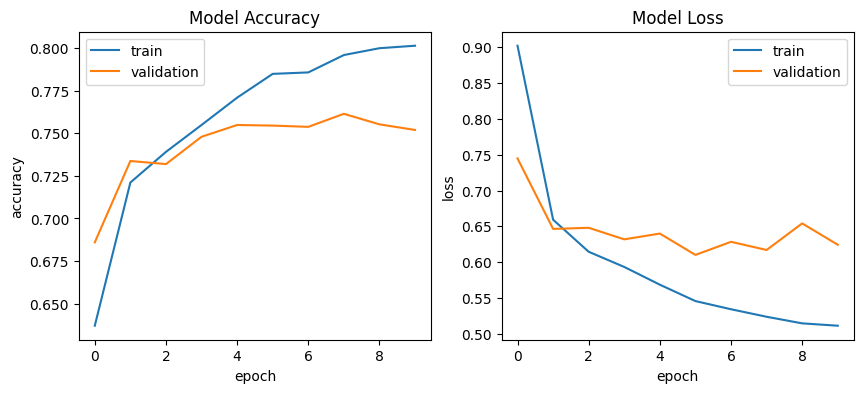

In [177]:
def plot_training_hist(history):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
  
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

In [178]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(input_dim=vocab_size_sn, output_dim=embed_size_sn, input_length=maxLen),
    LSTM(64, return_sequences=True),  # First LSTM layer
    Dropout(0.2),  # Dropout for regularization
    LSTM(32, return_sequences=True),  # Second LSTM layer
    Dropout(0.2),  # Dropout for regularization
    LSTM(32),  # Third LSTM layer, no return_sequences to flatten the output
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model to verify architecture
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 32, 32)            96000     
                                                                 
 lstm_19 (LSTM)              (None, 32, 64)            24832     
                                                                 
 dropout_13 (Dropout)        (None, 32, 64)            0         
                                                                 
 lstm_20 (LSTM)              (None, 32, 32)            12416     
                                                                 
 dropout_14 (Dropout)        (None, 32, 32)            0         
                                                                 
 lstm_21 (LSTM)              (None, 32)                8320      
                                                                 
 dense_10 (Dense)            (None, 3)               

In [179]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), 
                    epochs=10,
                    batch_size=64,
                    callbacks=[checkpoint])


Epoch 1/10
129/129 [==============================] - 5s 23ms/step - loss: 0.8974 - accuracy: 0.6322 - val_loss: 0.7401 - val_accuracy: 0.6816
Epoch 2/10
  7/129 [>.............................] - ETA: 2s - loss: 0.7242 - accuracy: 0.7031

/Users/nikhiljemili/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 3s 21ms/step - loss: 0.6571 - accuracy: 0.7201 - val_loss: 0.6911 - val_accuracy: 0.6995
Epoch 3/10
129/129 [==============================] - 3s 21ms/step - loss: 0.6114 - accuracy: 0.7477 - val_loss: 0.6976 - val_accuracy: 0.7311
Epoch 4/10
129/129 [==============================] - 3s 21ms/step - loss: 0.6004 - accuracy: 0.7537 - val_loss: 0.6574 - val_accuracy: 0.7472
Epoch 5/10
129/129 [==============================] - 3s 21ms/step - loss: 0.5823 - accuracy: 0.7668 - val_loss: 0.6285 - val_accuracy: 0.7548
Epoch 6/10
129/129 [==============================] - 3s 21ms/step - loss: 0.5559 - accuracy: 0.7813 - val_loss: 0.6175 - val_accuracy: 0.7596
Epoch 7/10
129/129 [==============================] - 3s 21ms/step - loss: 0.5404 - accuracy: 0.7923 - val_loss: 0.6161 - val_accuracy: 0.7479
Epoch 8/10
129/129 [==============================] - 3s 21ms/step - loss: 0.5334 - accuracy: 0.7962 - val_loss: 0.6243 - val_accuracy: 0.7435
Epoch 9/10

In [180]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

115/115 [==============================] - 0s 3ms/step - loss: 0.6051 - accuracy: 0.7607
Test Loss: 0.6051265001296997
Test Accuracy: 0.7606557607650757


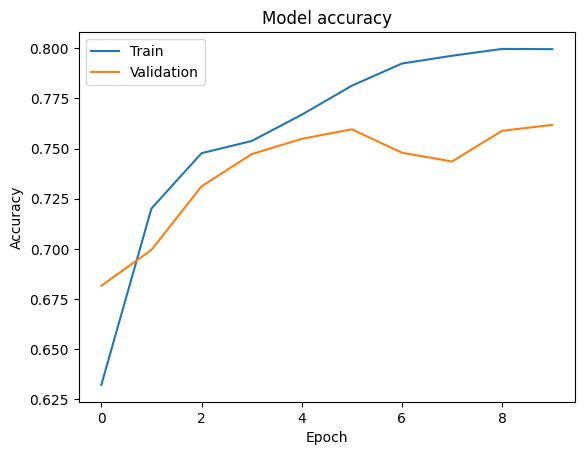

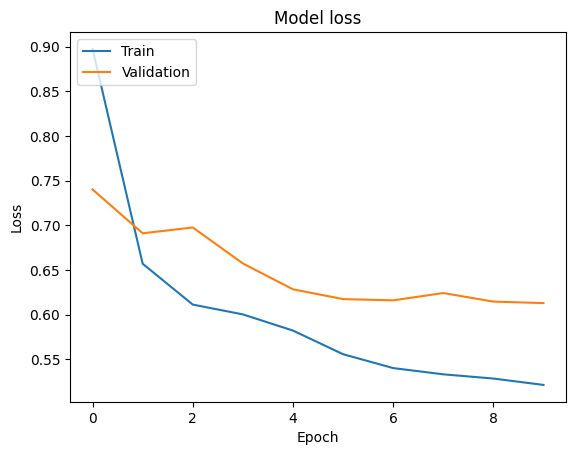

In [181]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [182]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Improving the model efficiecny by using the Biderictional LSTM and we are using two layers of the same.
efficiency_improved_model = Sequential([
    Embedding(input_dim=vocab_size_sn, output_dim=embed_size_sn, input_length=maxLen),
    Bidirectional(LSTM(64, return_sequences=True)),  # First bidirectional layer
    Dropout(0.5),
    Bidirectional(LSTM(64)),  # Second bidirectional layer, flattened output
    Dense(3, activation='sigmoid')  # Output layer for classification
])

# Compilation of the model
adam_optimizer = Adam(learning_rate=0.001)
sgd_optimizer = SGD(learning_rate=first_learningrate, momentum=momentum_rate, decay=lr_decay, nesterov=False)
efficiency_improved_model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
#efficiency_improved_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.005), metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint('best_efficiency_improved_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Fitting the model
history_improved = efficiency_improved_model.fit(train_data, train_labels, epochs=10, batch_size=64,
                                       validation_data=(val_data, val_labels),
                                       callbacks=[checkpoint_callback])
# Evaluate the best model on the test set
test_loss, test_accuracy = efficiency_improved_model.evaluate(test_data, test_labels)
print(f"Improved Model Test Loss: {test_loss}")
print(f"Improved Model Test Accuracy: {test_accuracy}")


Epoch 1/10
129/129 [==============================] - 5s 28ms/step - loss: 0.7910 - accuracy: 0.6583 - val_loss: 0.6611 - val_accuracy: 0.6998
Epoch 2/10
  7/129 [>.............................] - ETA: 2s - loss: 0.6308 - accuracy: 0.7031

/Users/nikhiljemili/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 3s 25ms/step - loss: 0.6226 - accuracy: 0.7366 - val_loss: 0.6376 - val_accuracy: 0.7428
Epoch 3/10
129/129 [==============================] - 3s 25ms/step - loss: 0.5790 - accuracy: 0.7619 - val_loss: 0.5916 - val_accuracy: 0.7581
Epoch 4/10
129/129 [==============================] - 3s 25ms/step - loss: 0.5431 - accuracy: 0.7749 - val_loss: 0.5961 - val_accuracy: 0.7585
Epoch 5/10
129/129 [==============================] - 3s 25ms/step - loss: 0.5229 - accuracy: 0.7845 - val_loss: 0.6449 - val_accuracy: 0.7581
Epoch 6/10
129/129 [==============================] - 3s 25ms/step - loss: 0.5171 - accuracy: 0.7877 - val_loss: 0.6104 - val_accuracy: 0.7530
Epoch 7/10
129/129 [==============================] - 3s 25ms/step - loss: 0.5107 - accuracy: 0.7911 - val_loss: 0.6003 - val_accuracy: 0.7588
Epoch 8/10
129/129 [==============================] - 3s 27ms/step - loss: 0.5021 - accuracy: 0.7915 - val_loss: 0.6127 - val_accuracy: 0.7559
Epoch 9/10

In [183]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Testing with one of the possible dummy input to test the model predictions
def predict_sentiment_improved(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw, maxlen=maxLen)  # Ensuring thaat the maximum length of the input should match with the length the modle is using for training 
    prediction = efficiency_improved_model.predict(tw)
    sentiment_label = {1: 'positive', 0: 'negative', 2: 'neutral'}
    predicted_label = sentiment_label[prediction.argmax(axis=1)[0]]
    
    print("Predicted label: ", predicted_label)
test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment_improved(test_sentence1)
test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment_improved(test_sentence2)


1/1 [==============================] - 0s 431ms/step
Predicted label:  positive
1/1 [==============================] - 0s 9ms/step
Predicted label:  negative


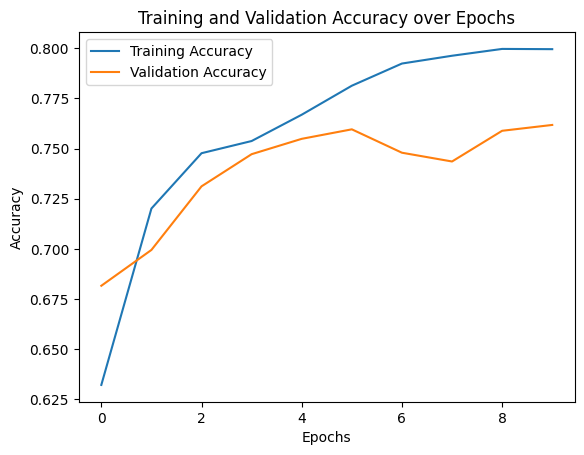

In [184]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

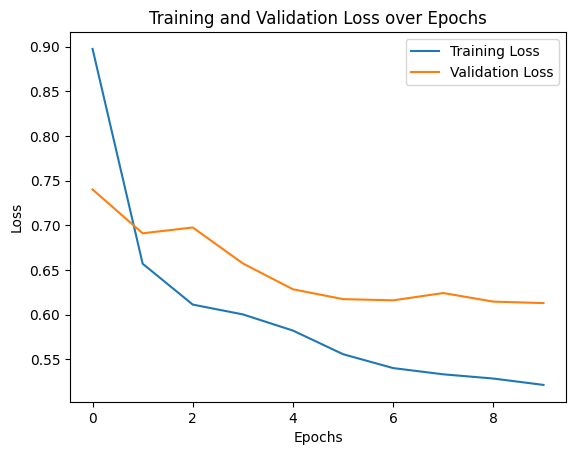

In [185]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

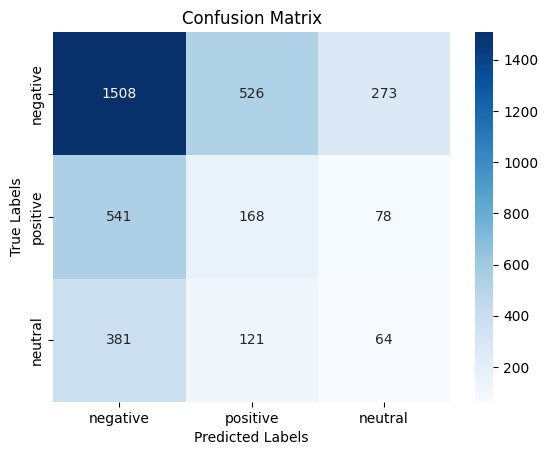

In [186]:
# Visualisation of the confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels.values, axis=1), y_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()